In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation
from matplotlib.gridspec import GridSpec

In [2]:
def angle_generator_x(angle):
    R = np.zeros(shape=(3,3))
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R[0,0] = 1
    R[1,1] = c
    R[1,2] = -s
    R[2,1] = s
    R[2,2] = c
    return R

def angle_generator_y(angle):
    R = np.zeros(shape=(3,3))
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R[1,1] = 1
    R[0,0] = c
    R[2,0] = -s
    R[0,2] = s
    R[2,2] = c
    return R

def angle_generator_z(angle):
    R = np.zeros(shape=(3,3))
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R[2,2] = 1
    R[0,0] = c
    R[0,1] = -s
    R[1,0] = s
    R[1,1] = c
    return R

In [3]:
def array_rotator_x(array, angle):
    rotated_array = np.empty(array.shape)
    R = angle_generator_x(angle)
    for i in range(len(array)):
        rotated_array[i, :] =  np.dot(R, array[i,:])  
    
    return rotated_array

def array_rotator_y(array, angle):
    rotated_array = np.empty(array.shape)
    R = angle_generator_y(angle)
    for i in range(len(array)):
        rotated_array[i, :] =  np.dot(R, array[i,:])  
    
    return rotated_array

def array_rotator_z(array, angle):
    rotated_array = np.empty(array.shape)
    R = angle_generator_z(angle)
    for i in range(len(array)):
        rotated_array[i, :] =  np.dot(R, array[i,:])  
    
    return rotated_array
 

In [4]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [5]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
lons = np.array(others.variables['lon'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [6]:
z_test_tsne_track_31_sam = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/model_graphs/latent_space/Small_UM_3D_PCA_Latent_Space__4503.npy')

# Land Fraction Calculator

In [7]:
path = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h0.2008-11.nc'
next_ds = xr.open_dataset(path)

#land fraction
land_frac = next_ds.LANDFRAC
land_frac = xr.DataArray.squeeze(land_frac).values

trop_land = land_frac[37:59, :]

In [8]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)

lat_keys_spcam = np.arange(0,22,1)
lat_values_spcam = latitudes
lon_keys_spcam = np.arange(0,144,1)
lon_values_spcam = longitudes

lat_dic_spcam = dict(zip(lat_values_spcam, lat_keys_spcam))
lon_dic_spcam = dict(zip(lon_values_spcam, lon_keys_spcam))

In [9]:
lat_test_spcam = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/SAM_ORIGIN/Small_Unscaled_MY_SAM_Lat_Test.npy')
lon_test_spcam  = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/SAM_ORIGIN/Small_Unscaled_MY_SAM_Lon_Test.npy')

lat_test_ifs = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/UM/Raw_Small_Unscaled_UM_Lat_Test.npy')
lon_test_ifs  = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/UM/Raw_Small_Unscaled_UM_Lon_Test.npy')

In [10]:
ifs_land_frac = np.empty(shape=(len(z_test_tsne_track_31_sam)))
       
for i in range(len(ifs_land_frac)):
    lat = latitudes.flat[np.abs(latitudes - lat_test_ifs[i]).argmin()]
    lon = longitudes.flat[np.abs(longitudes - (lon_test_ifs[i]+180.)).argmin()]
    if lon_dic_spcam[lon] <= 71:
        ifs_land_frac[i] = trop_land[lat_dic_spcam[lat],lon_dic_spcam[lon]+72]
    else:
        ifs_land_frac[i] = trop_land[lat_dic_spcam[lat],72-(144-lon_dic_spcam[lon])]  

In [11]:
labels_3_SAM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Small_UM_Labels_4503_Z_3.npy")
W_500_w_test_SAM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Labels/4802_tke_UM.npy")
EQ_1_ww_test_SAM_profile = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Labels/4802_EQ_1_ww_test_UM_profile.npy")

# 4 Panel Figure For SI Paper

Text(0.5, 0.95, 'UM Trained VAE 3D Latent Space Projections')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found.

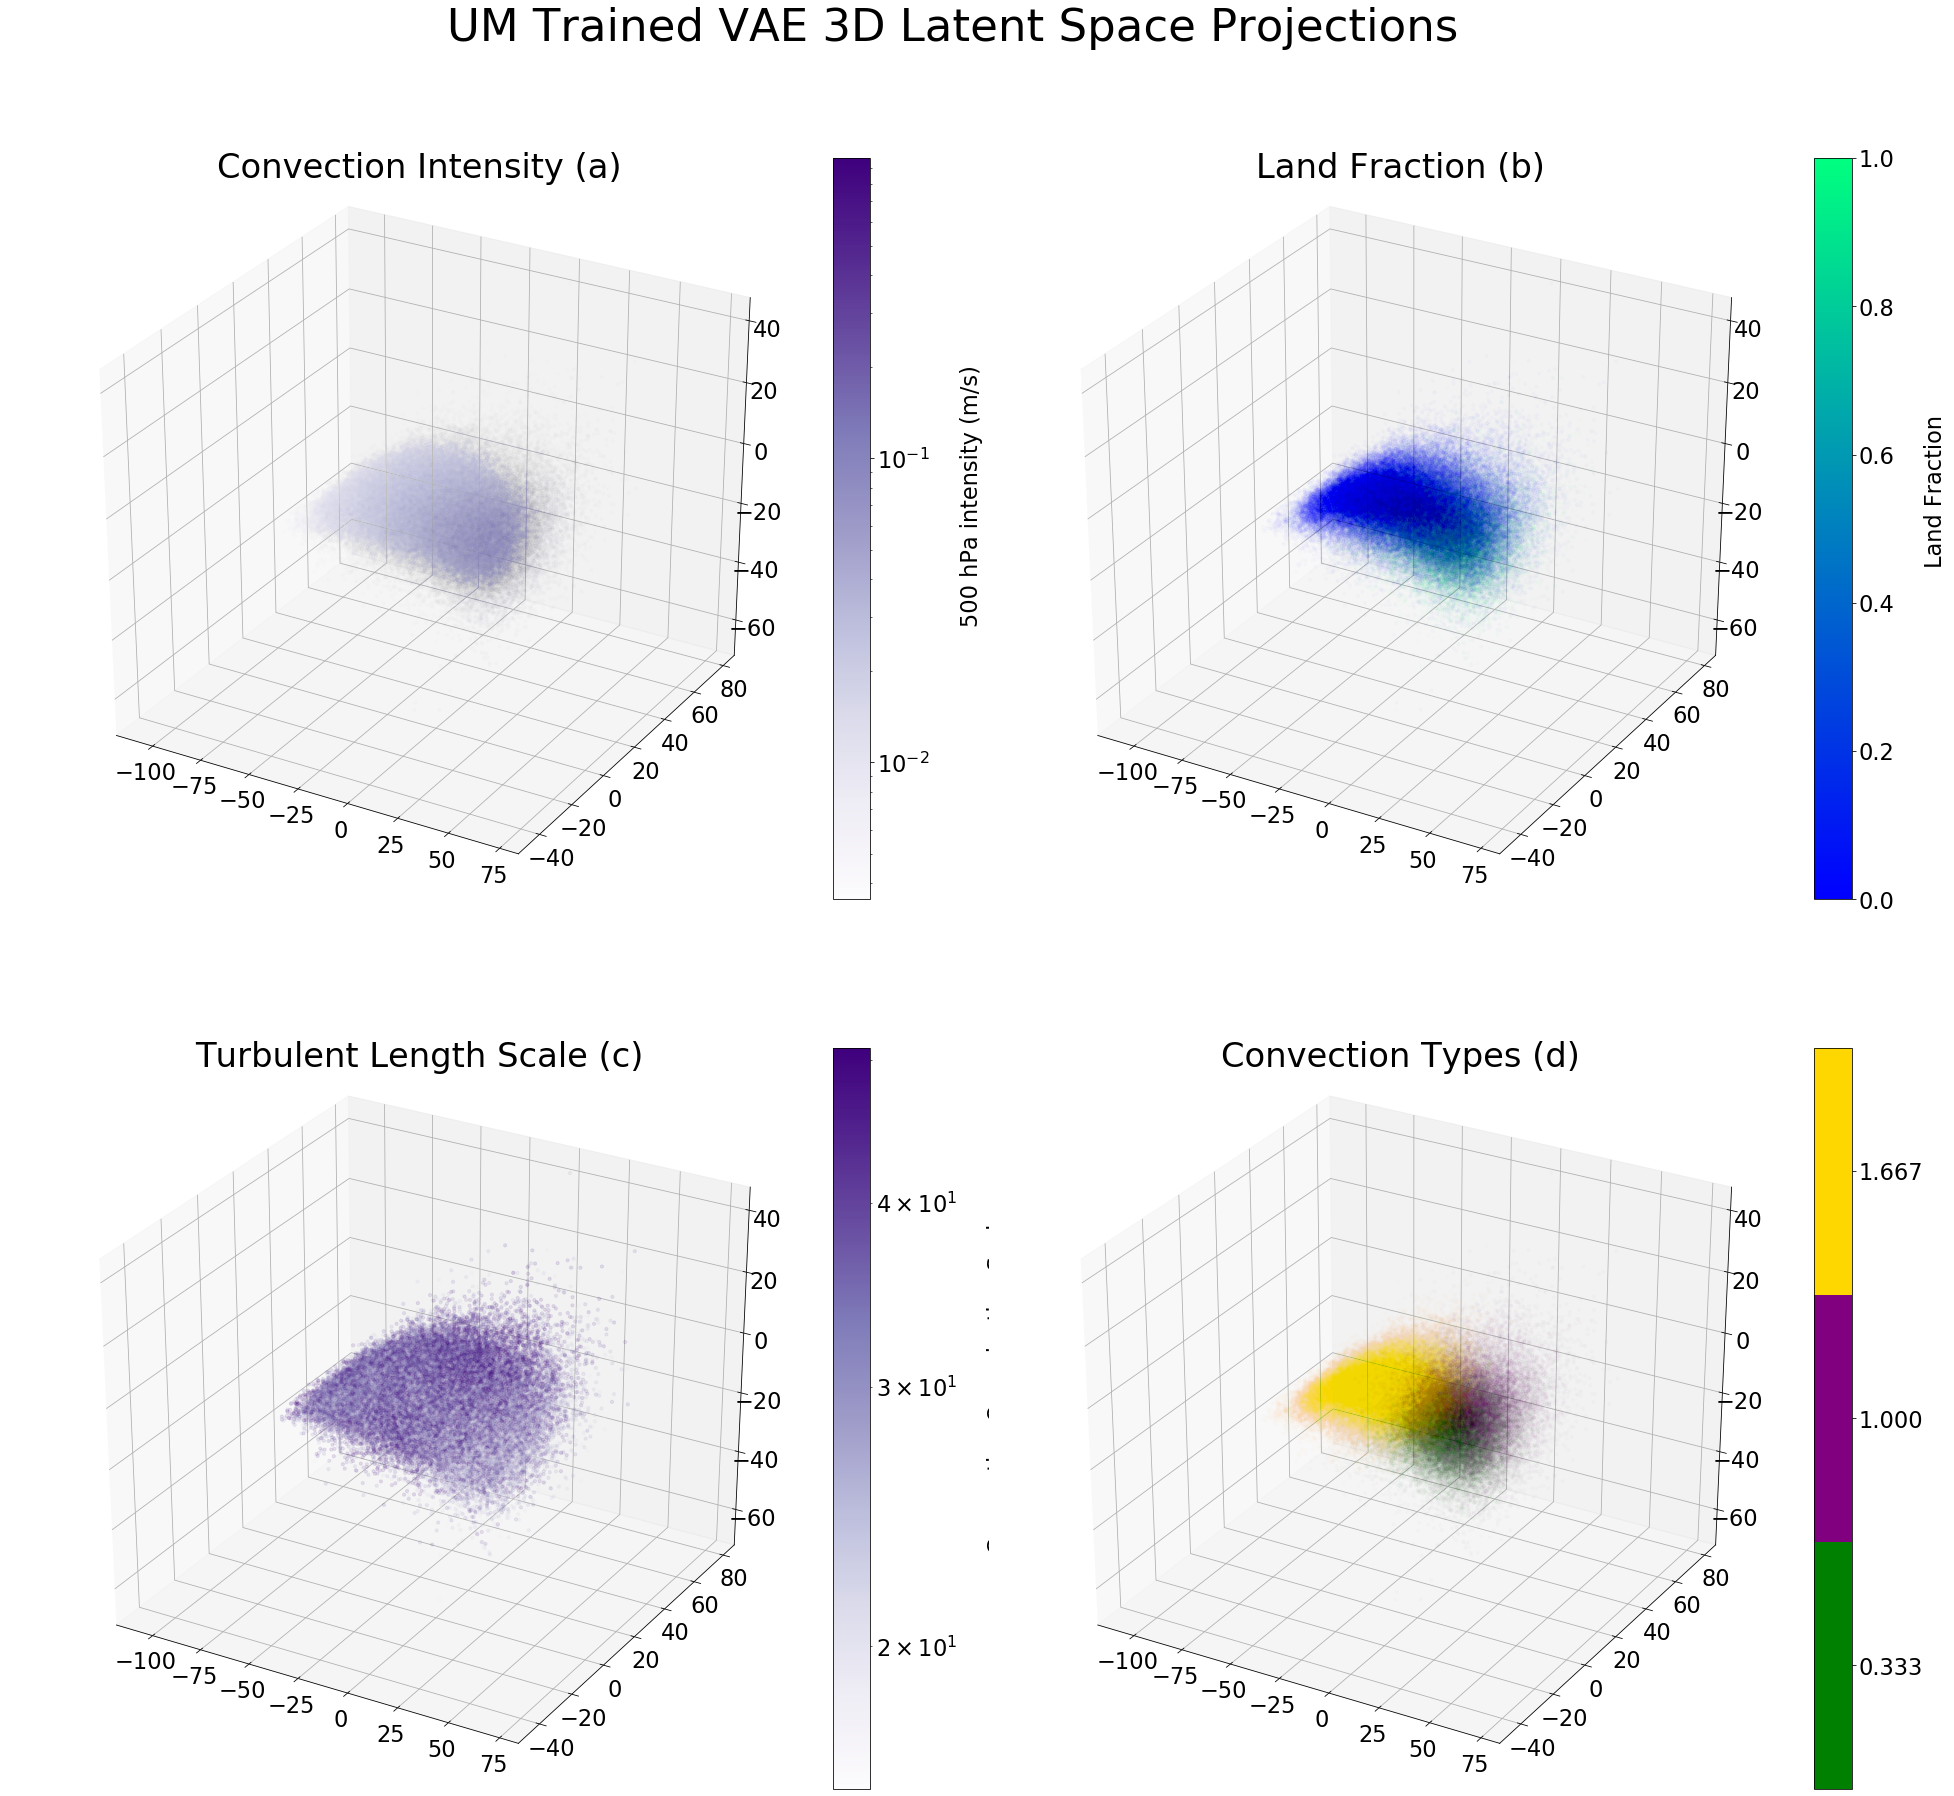

In [12]:
fig, ax = plt.subplots(2,2,figsize=(35,30))
gs=GridSpec(2,2)

vmin = 0.01
vmax = 1

ax1 = fig.add_subplot(gs[0,0], projection='3d')

cp = ax1.scatter(xs=z_test_tsne_track_31_sam[:, 0], ys=z_test_tsne_track_31_sam[:, 1], zs=z_test_tsne_track_31_sam[:, 2], c=W_500_w_test_SAM, cmap="Purples", s=10.0, norm=matplotlib.colors.LogNorm(), alpha=0.01)
ax1.set_title("Convection Intensity (a)", fontsize = fz*1.5, y = 1.05)

cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label='500 hPa intensity (m/s) ', rotation="vertical", labelpad=30, y = 0.55)
cbar.set_alpha(1)
cbar.draw_all()

ax1.set_xlim(-115,80)
ax1.set_ylim(-50,85)
ax1.set_zlim(-70,45)

ax2 = fig.add_subplot(gs[0,1], projection='3d')
vmin = 0
vmax = 1
cp = ax2.scatter(xs=z_test_tsne_track_31_sam[:, 0], ys=z_test_tsne_track_31_sam[:, 1], zs=z_test_tsne_track_31_sam[:, 2], c=ifs_land_frac, cmap="winter", s=10.0, vmin=vmin, vmax=vmax, alpha=0.01)
ax2.set_title("Land Fraction (b)", fontsize = fz*1.5, y = 1.05)

ax2.set_xlim(-115,80)
ax2.set_ylim(-50,85)
ax2.set_zlim(-70,45)

cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label="Land Fraction", rotation="vertical", labelpad=30, y = 0.55)
cbar.set_alpha(1)
cbar.draw_all()

ax3 = fig.add_subplot(gs[1,0], projection='3d')

vmin=2
vmax=256

cp = ax3.scatter(xs=z_test_tsne_track_31_sam[:, 0], ys=z_test_tsne_track_31_sam[:, 1], zs=z_test_tsne_track_31_sam[:, 2], c=EQ_1_ww_test_SAM_profile, cmap="Purples", s=10.0, norm=matplotlib.colors.LogNorm(), vmin=16, vmax=51.0, alpha=0.1)
ax3.set_title("Turbulent Length Scale (c)", fontsize = fz*1.5, y = 1.05)

ax3.set_xlim(-115,80)
ax3.set_ylim(-50,85)
ax3.set_zlim(-70,45)

cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label="Convective Organization Scale", rotation="vertical", labelpad=30, y = 0.55)
cbar.set_alpha(1)
cbar.draw_all()

ax4 = fig.add_subplot(gs[1,1], projection='3d')

cmap = matplotlib.colors.ListedColormap(["green","purple","gold"])
#cmap = matplotlib.colors.ListedColormap(["green","gold","purple"])

cp = ax4.scatter(xs=z_test_tsne_track_31_sam[:, 0], ys=z_test_tsne_track_31_sam[:, 1], zs=z_test_tsne_track_31_sam[:, 2], c=labels_3_SAM, cmap=cmap, s=10.0, alpha=0.01)
ax4.set_title("Convection Types (d)", fontsize = fz*1.5, y = 1.05)

ax4.set_xlim(-115,80)
ax4.set_ylim(-50,85)
ax4.set_zlim(-70,45)


#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.82, 0.12, 0.01, 0.76])
#cbar = fig.colorbar(cp, cax=cbar_ax)

cbar = fig.colorbar(cp, pad=0.002)
#cbar.set_label(label="Convective Organization Scale", rotation="vertical", labelpad=30, y = 0.55)

n_clusters=3
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar.set_ticks(tick_locs)

cbar.ax.set_yticklabels(["Continental","Deep","Shallow Marine"], fontsize=fz)
#cbar.ax.set_yticklabels(["Deep","Shallow Marine","Continental"], fontsize=fz)
cbar.ax.tick_params(labelsize=fz)
cbar.set_alpha(1)
cbar.draw_all()

fig.delaxes(ax[0,0])
fig.delaxes(ax[0,1])
fig.delaxes(ax[1,0])
fig.delaxes(ax[1,1])

plt.subplots_adjust(wspace=0.01)

plt.suptitle("UM Trained VAE 3D Latent Space Projections", fontsize = fz*2.0, y = 0.95)

#for ii in range(360):
#    ax1.view_init(elev=30, azim=ii)
#    ax2.view_init(elev=30, azim=ii)
#    ax3.view_init(elev=30, azim=ii)
#    ax4.view_init(elev=30, azim=ii)
#    if ii < 10:
#        plt.savefig("../Png_Storage/Movie_S1/00"+str(ii)+".png")
#    if ii >= 10 and ii < 100:
#        plt.savefig("../Png_Storage/Movie_S1/0"+str(ii)+".png")
#    if ii >= 100:
#        plt.savefig("../Png_Storage/Movie_S1/"+str(ii)+".png")